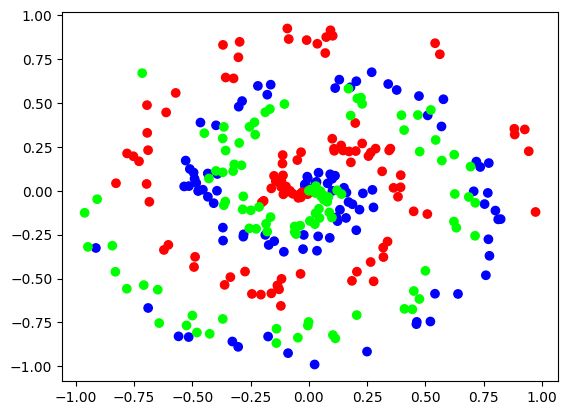

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs.datasets

X,y=nnfs.datasets.spiral_data(100,3)
plt.scatter(X[:,0],X[:,1],c=y,cmap='brg')
plt.show()

## Class For Dense Layer 

In [2]:
class Dense:
    def __init__(self, n_inputs, n_nueorns):
        self.weigths = 0.01 * np.random.randn(n_inputs, n_nueorns)
        self.biases = np.zeros((1, n_nueorns))

    def forward(self, inputs) -> np.array:
        self.inputs = inputs
        self.outputs = np.dot(inputs, self.weigths) + self.biases

    def backward(self, dvalues):
        self.dweigths = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weigths.T)

## Class for ReLU

In [3]:
class ReLU:
    def forward(self, x):
        self.inputs = x
        self.outputs = np.maximum(0, x)

    def backward(self, dvalues: list):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

## Class for Softmax and Loss Combined

In [4]:
class Loss:
    def calculate(self, y_pred, y_true):
        loss = self.forward(y_pred, y_true)
        return np.mean(loss)


class SoftMax:
    def forward(self, inputs):
        exp_val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        prob = exp_val / np.sum(exp_val, axis=1, keepdims=True)
        self.outputs = prob


class CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        y_clip = np.clip(y_pred, 1e-9, 1 - 1e-9)
        if len(y_true.shape) == 1:
            confidence_val = y_clip[
                range(len(y_pred)), y_true
            ]  ## for Sparse_categoricalCrossEntropy case
        else:
            confidence_val = np.sum(y_pred * y_true)  ## for Categorical Outputs
        return -np.log(confidence_val)

    def backward(self, dvalues, y_true):
        samples = len(y_true)
        labels = len(len(dvalues)[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples


class SotMax_Loss_CategoricalCrossEntropy:
    def __init__(self):
        self.activation = SoftMax()
        self.loss = CategoricalCrossEntropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.outputs = self.activation.outputs
        return self.loss.calculate(self.outputs, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

In [5]:
dense_1 = Dense(X.shape[1], 3)
activation_1 = ReLU()

dense_2 = Dense(3, 3)
activation_2 = SotMax_Loss_CategoricalCrossEntropy()

dense_1.forward(X)
activation_1.forward(dense_1.outputs)

dense_2.forward(activation_1.outputs)
loss=activation_2.forward(dense_2.outputs,y)

print("Output in Forward Pass : ", activation_2.outputs[:3])
print("Loss : ",loss)

Output in Forward Pass :  [[0.33333333 0.33333333 0.33333333]
 [0.33333357 0.33333378 0.33333266]
 [0.33333356 0.33333387 0.33333257]]
Loss :  1.0986097235389622


In [6]:
predictions = np.argmax(activation_2.outputs, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
acc = np.mean(predictions == y)
print("Accuracy in Single Forward Pass : ",acc)

Accuracy in Single Forward Pass :  0.2966666666666667


In [7]:
activation_2.backward(activation_2.outputs,y)
dense_2.backward(activation_2.dinputs)

activation_1.backward(dense_2.dinputs)
dense_1.backward(activation_1.dinputs)

print(dense_1.dweigths)
print(dense_1.dbiases)
print(dense_2.dweigths)
print(dense_2.dbiases)

[[ 2.49538243e-04 -5.43503007e-05 -1.06757617e-04]
 [-2.89610257e-04  1.44242360e-04 -3.86845491e-04]]
[[ 6.82798572e-04 -9.03259093e-05 -4.33829433e-04]]
[[-1.27665262e-04  1.36630584e-04 -8.96532221e-06]
 [-8.32343341e-05  6.04651122e-06  7.71878229e-05]
 [-5.94660744e-06 -2.25219060e-04  2.31165668e-04]]
[[-1.46455411e-06  1.35090290e-05 -1.20444749e-05]]


## Combined All

In [27]:
dense_1 = Dense(X.shape[1], 3)
activation_1 = ReLU()

dense_2 = Dense(3, 3)
activation_2 = SotMax_Loss_CategoricalCrossEntropy()

dense_1.forward(X)
activation_1.forward(dense_1.outputs)

dense_2.forward(activation_1.outputs)
loss=activation_2.forward(dense_2.outputs,y)

print("Output in Forward Pass : ", activation_2.outputs[:3])
print("Loss : ",loss)

predictions = np.argmax(activation_2.outputs, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
acc = np.mean(predictions == y)
print("Accuracy in Single Forward Pass : ",acc)

activation_2.backward(activation_2.outputs,y)
dense_2.backward(activation_2.dinputs)

activation_1.backward(dense_2.dinputs)
dense_1.backward(activation_1.dinputs)

print(dense_1.dweigths)
print(dense_1.dbiases)
print(dense_2.dweigths)
print(dense_2.dbiases)

Output in Forward Pass :  [[0.33333333 0.33333333 0.33333333]
 [0.33333321 0.33333367 0.33333312]
 [0.333333   0.33333493 0.33333206]]
Loss :  1.0986114853845284
Accuracy in Single Forward Pass :  0.36
[[ 1.18944928e-04 -7.58620741e-05 -2.58139135e-04]
 [ 1.77351005e-04 -5.50834210e-04 -1.65785882e-06]]
[[ 2.35341526e-05 -6.11394273e-04  7.63381564e-04]]
[[-2.03254507e-04  9.79684200e-05  1.05286087e-04]
 [ 2.08282768e-04 -2.41404099e-04  3.31213308e-05]
 [ 4.22583510e-05  7.49137026e-05 -1.17172054e-04]]
[[-1.41834354e-07  1.01374401e-05 -9.99560576e-06]]
